# Using MarkovModels.jl

This notebook shows how to use the [MarkovModels.jl](https://github.com/lucasondel/MarkovModels.jl) package to compute the forward-backward algorithm.


In [2]:
using Pkg
Pkg.activate("../")

using Plots
using SparseArrays

using Revise
using MarkovModels

  Activating environment at `~/Repositories/MarkovModels.jl/Project.toml`


## Computing the state posteriors


### Inference graph

The first step is to define the computation type for the FSM. Unless you know what you are doing, always use `LogSemifield{..}`!!

In [4]:
T = Float32
SF = LogSemifield{T} 

LogSemifield{Float32}

Now, we create the inference graph:

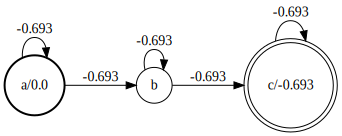

In [7]:
fsm = VectorFSM{SF}()
S = 3 # Number of states

labels = ["a", "b", "c"]

prev = addstate!(fsm, labels[1], initweight = one(SF))
addarc!(fsm, prev, prev)
for s in 2:S
    fw = s == S ? one(SF) :  zero(SF)
    state = addstate!(fsm, labels[s]; finalweight = fw)
    addarc!(fsm, prev, state)
    addarc!(fsm, state, state)
    prev = state
end

fsm |> renormalize

### Compilation

The second step is to put it in an inference-easy format. This is done by creating a `MatrixFSM`, an FSM which is stored in matrix format.

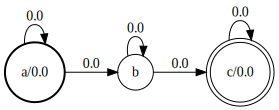

In [9]:
label2pdfid = Dict(
    "a" => 1,
    "b" => 2,
    "c" => 3
)
mfsm = MatrixFSM(fsm, label2pdfid)

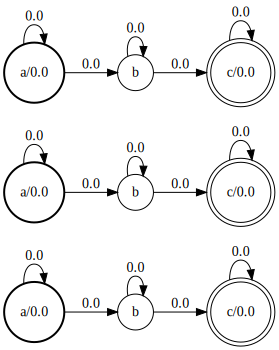

In [23]:
union(mfsm, mfsm, mfsm)

Just for information, `cfsm` has, among others, the following attributes:
* `cfsm.π` log-probability of the initial state
* `cfsm.ω` log-probability of the final state
* `cfsm.T` log-probability of the state transitions

However, you don't need to use them directly in most cases.

### Forward-Backward algorithm
 
For the sake of the example, we simulate some pseudo-loglikelihood:

In [24]:
B = 2 # number of batches
S = length(collect(states(mfsm))) # number of states
N = 5 # number of frames
lhs = zeros(T, S, N)

3×5 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0

Now to compute the forward-backward algorithm we just have to do:

In [25]:
γ, ttl = MarkovModels.pdfposteriors(mfsm, lhs)
γ

3×5 Matrix{Float32}:
 1.0  0.5  0.166667  0.0  0.0
 0.0  0.5  0.666667  0.5  0.0
 0.0  0.0  0.166667  0.5  1.0

where `γ` is a matrix of conditional probabilities and `ttl` is the total log-probability of sequence.

To get the probability we need to convert `lnγ` to the natural semifield and take the element-wise exponential: 

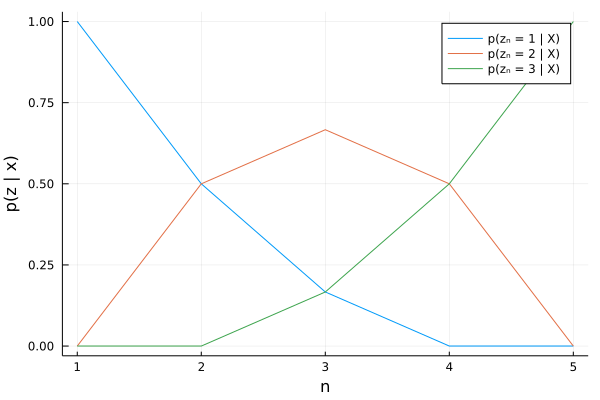

In [26]:
p = plot(xlabel = "n", ylabel = "p(z | x)")
for s in 1:S
    plot!(p, γ[s, :], label = "p(zₙ = $s | X)")
end
p

## Best path

In this section, we show how to compute the most likely state path, i.e.:
$$
    z_1^*, \dots, z_N^* = \text{argmax}_{z_1,\dots,z_n} p(z_1, \dots, z_N | x_1, \dots, x_N)
$$

### Inference graph

we consider a slighlty more complex graph:

In [21]:
fsm = FSM{SF}()
S = 3 # number of states per branch

labels = ["a" "b" "c";
          "d" "e" "f"]

prev1 = addstate!(fsm, pdfindex = 1, label = labels[1,1])
prev2 = addstate!(fsm, pdfindex = 4, label = labels[2,1])
link!(fsm, prev1, prev1)
link!(fsm, prev2, prev2)
setinit!(prev1)
setinit!(prev2)
for s in 2:S
    state1 = addstate!(fsm, pdfindex = s, label = "$(labels[1,s])")
    state2 = addstate!(fsm, pdfindex = S+s, label = "$(labels[2,s])")
    link!(fsm, prev1, state1)
    link!(fsm, prev2, state2)
    link!(fsm, state1, state1)
    link!(fsm, state2, state2)
    prev1 = state1
    prev2 = state2
end
setfinal!(prev1)
setfinal!(prev2)

fsm |> renormalize!

LoadError: UndefVarError: FSM not defined

As before, we compile the FSM:

In [630]:
cfsm = compile(fsm, allocator = zeros)

CompiledFSM{LogSemifield{Float32}}(LogSemifield{Float32}[-0.6931472, -Inf, -Inf, -0.6931472, -Inf, -Inf], LogSemifield{Float32}[-Inf, -Inf, -0.6931472, -Inf, -Inf, -0.6931472], LogSemifield{Float32}[-0.6931472 -0.6931472 … -Inf -Inf; -Inf -0.6931472 … -Inf -Inf; … ; -Inf -Inf … -0.6931472 -0.6931472; -Inf -Inf … -Inf -0.6931472], LogSemifield{Float32}[-0.6931472 -Inf … -Inf -Inf; -0.6931472 -0.6931472 … -Inf -Inf; … ; -Inf -Inf … -0.6931472 -Inf; -Inf -Inf … -0.6931472 -0.6931472], [2, 1, 0, 2, 1, 0], [1, 4, 2, 5, 3, 6])

We generate some new pseudo-loglikelihoods:

In [631]:
B = 2 # number of batches
S = length(cfsm.π) # number of states
N = 10 # number of frames
lhs = randn(T, S, N)

6×10 Matrix{Float32}:
  2.54074   -1.80856   -0.17281   …  -0.407999    0.218859    0.770468
 -1.80078   -0.972472  -0.868457      0.998495   -0.256131    0.69585
  0.354606   1.33451    0.682232      0.911172   -1.87985     0.422622
  1.56591   -0.389978  -1.21095      -1.39417     0.946198   -1.83486
  1.40867    0.488417   0.403639      0.699445    0.858844    0.440268
 -0.992897  -0.175782   2.24523   …  -0.0871825  -0.0308358   0.432622

and we compute the most likely path:

In [632]:
path, pathlhs = MarkovModels.bestpath(cfsm, lhs)

([1, 1, 1, 1, 1, 2, 2, 2, 2, 3], TropicalSemifield{Float32}[2.540742, 2.540742, 2.540742, 2.540742, 2.540742, -1.8007803, -1.8007803, -1.8007803, -1.8007803, 0.35460642])